# IMPORTS AND LIBRARIES

In [ ]:
!pip install cfbd

In [ ]:
# Data
import cfbd

# General
import time
import math
import datetime

# Data & Modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

# Specific sklearn models
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

# Specific tensorflow layers,optimizers,etc.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

# LOADING THE API

LOAD THE API CONFIGURATION

In [ ]:
# configure API key
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '4OCTdkOLAKQ8szaP0w1Bqm/pCQ4yM053B9kTUwlN7/XN56Y9dOxidmYypMYAmr/I'
configuration.api_key_prefix['Authorization'] = 'Bearer'

# instantiate a games API instance
api_config = cfbd.ApiClient(configuration)

LOAD THE SPECIFIC APIS

In [ ]:
# load the specific apis to use
# yearly apis
games_api = cfbd.GamesApi(api_config)
teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
drives_api = cfbd.DrivesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

# static apis
conferences_api = cfbd.ConferencesApi(api_config)
venues_api = cfbd.VenuesApi(api_config)

LOAD THE ACTUAL DATA FROM THE API, DATA IS LOADED IN STATIC AND YEARLY FRAMES

In [ ]:
startTime = time.time()

games = []
# drives = []
ratings = []
teams = []
teams_records = []
teams_season_stats = []
# teams_game_stats = []
teams_talent = []
conferences = []
venues = []

# yearly data requests
for year in range(2019, 2022):
  game_response = games_api.get_games(year=year)
  games = [*games, *game_response]

  # drive_response = drives_api.get_drives(year=year)
  # drives = [*drives, *drive_response]

  teams_records_response = games_api.get_team_records(year=year)
  teams_records = [*teams_records, *teams_records_response]

  season_stats_response = stats_api.get_advanced_team_season_stats(year=year)
  teams_season_stats = [*teams_season_stats, *season_stats_response]

  # game_stats_response = stats_api.get_advanced_team_game_stats(year=year)
  # teams_game_stats = [*teams_game_stats, game_stats_response]

  team_talent_response = teams_api.get_talent(year=year)
  teams_talent = [*teams_talent, *team_talent_response]


# non-yearly data requests
# team data
response = teams_api.get_teams()
teams = [*teams, *response]

# # conference data
# response = conferences_api.get_conferences()
# conferences = [*conferences, *response]

# venue data
response = venues_api.get_venues()
venues = [*venues, *response]

response = ratings_api.get_elo_ratings(year=year)
ratings = [*ratings, *response]

# get_advanced_team_game_stats ends up with a list containing a single list, this fixes that
# teams_game_stats = teams_game_stats[0]

print("Collecting data from the CFBD api took: {} seconds".format(round(time.time() - startTime, 1)))

CLEAR OUT ROWS WITH MISSING DATA

In [ ]:
startTime = time.time()

# clears out games with undefined data
games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]
# clears out teams with undefined conferences and locations
teams = [t for t in teams if t.conference is not None and t.division is not None and t.location['latitude'] is not None and t.location['longitude'] is not None]
# clears venues with no latitude and longitude
venues = [v for v in venues if v.location is not None]
# clears team season and game stats 
teams_season_stats = [t for t in teams_season_stats if t.conference is not None]
# teams_game_stats = [g for g in teams_game_stats if g.offense is not None and g.defense is not None]

print("Clearing invalid entries took: {} seconds".format(round(time.time() - startTime, 1)))

Clearing invalid entries took: 0.0 seconds


# CREATING THE DATASET

## ORGANZING THE DATA

FILTER OUT UNUSED COLUMNS AND CONVERT DATA INTO LISTS OF DICTS

In [ ]:
startTime = time.time()

# filter out the information that will be used for each game entry
def game_to_dict(g):
  return dict(
         id = g.id,
         year = g.season,
         venue_id = g.venue_id,
         home_team = g.home_team,
         home_conference = g.home_conference,
         home_points = g.home_points,
         home_elo = g.home_pregame_elo,
         away_team = g.away_team,
         away_conference = g.away_conference,
         away_points = g.away_points,
         away_elo = g.away_pregame_elo)
dict_games = [game_to_dict(g) for g in games]

# filter out mascot, colors, alternative names, and some venue information
def team_to_dict(t):
  return dict(
         id = t.id,
         name = t.school,
         conference = t.conference,
         division = t.division,
         latitude = t.location['latitude'],
         longitude = t.location['longitude'],
         elevation = t.location['elevation'],
         grass = t.location['grass'],
         dome = t.location['dome'])
dict_teams = [team_to_dict(t) for t in teams]

# team results
def team_season_to_dict(r):
  return dict(
         year = r.year,
         team = r.team,
         conference = r.conference,
         division = r.division,
         expected_wins = r.expected_wins,
         total_games = r.total['games'],
         total_wins = r.total['wins'],
         total_losses = r.total['losses'],
         total_ties = r.total['ties'])
dict_team_season_results = [team_season_to_dict(r) for r in teams_records]

# reorganize teams_talent into a dict
def team_talent_to_dict(tt):
  return dict(
         name = tt.school,
         talent_score = tt.talent,
         year = tt.year) 
dict_teams_talent = [team_talent_to_dict(tt) for tt in teams_talent]

# organize team season stats into dictionary
def team_season_stats_to_dict(ss):
  return dict(
         team = ss.team,
         season = ss.season,
         conference = ss.conference,
         offense_drives = ss.offense['drives'],
         offense_explosiveness = ss.offense['explosiveness'],
         offense_lineyards = ss.offense['lineYards'],
         offense_lineyards_total = ss.offense['lineYardsTotal'],
         offense_openfieldyards = ss.offense['openFieldYards'],
         offense_openfieldyards_total = ss.offense['openFieldYardsTotal'],
         offense_plays = ss.offense['plays'],
         offense_ppo = ss.offense['pointsPerOpportunity'],
         offense_powersuccess = ss.offense['powerSuccess'],
         offense_ppa = ss.offense['ppa'],
         offense_stuffrate = ss.offense['stuffRate'],
         offense_successrate = ss.offense['successRate'],
         offense_totalopportunities = ss.offense['totalOpportunies'],
         offense_totalppa = ss.offense['totalPPA'],
         offense_havoc_total = ss.offense['havoc']['total'],
         offense_havoc_frontseven = ss.offense['havoc']['frontSeven'],
         offense_havoc_db = ss.offense['havoc']['db'],
         defense_drives = ss.defense['drives'],
         defense_explosiveness = ss.defense['explosiveness'],
         defense_lineyards = ss.defense['lineYards'],
         defense_lineyards_total = ss.defense['lineYardsTotal'],
         defense_openfieldyards = ss.defense['openFieldYards'],
         defense_openfieldyards_total = ss.defense['openFieldYardsTotal'],
         defense_plays = ss.defense['plays'],
         defense_ppo = ss.defense['pointsPerOpportunity'],
         defense_powersuccess = ss.defense['powerSuccess'],
         defense_ppa = ss.defense['ppa'],
         defense_stuffrate = ss.defense['stuffRate'],
         defense_successrate = ss.defense['successRate'],
         defense_totalopportunities = ss.defense['totalOpportunies'],
         defense_totalppa = ss.defense['totalPPA'],
         defense_havoc_total = ss.defense['havoc']['total'],
         defense_havoc_frontseven = ss.defense['havoc']['frontSeven'],
         defense_havoc_db = ss.defense['havoc']['db'])
dict_teams_season_stats = [team_season_stats_to_dict(ss) for ss in teams_season_stats]

# change each venue to have latitude longitude not the location dictionary
def venues_to_dict(v):
  return dict(
         id = v.id,
         name = v.name,
         grass = v.grass,
         dome = v.dome,
         latitude = v.location['x'],
         longitude = v.location['y'],
         elevation = v.elevation)
dict_venues = [venues_to_dict(v) for v in venues]

# function to take a ratings object and convert to dictionary
def rating_to_dict(r):
  return dict(
      year = r.year,
      team = r.team,
      conference = r.conference,
      elo = r.elo)
dict_ratings = [rating_to_dict(r) for r in ratings]

print("Reorganizing into lists of dictionaries took: {} seconds".format(round(time.time() - startTime, 1)))

Reorganizing into lists of dictionaries took: 0.0 seconds


REVERSE ~50% OF GAMES TO REMOVE HOME FIELD ADVANTAGE ENCODING FOR DATA POSITION

In [ ]:
# Function to reverse home and away teams in a dictionary describing a game
def reverse_teams(game):
  # game -> taken as a dictionary
  # returns new dictionary
  return dict(
      id = game['id'],
      year = game['year'],
      venue_id = game['venue_id'],
      home_team = game['away_team'],
      home_conference = game['away_conference'],
      home_points = game['away_points'],
      home_elo = game['away_elo'],
      away_team = game['home_team'],
      away_conference = game['home_conference'],
      away_points = game['home_points'],
      away_elo = game['home_elo']
  )

In [ ]:
startTime = time.time()
# shuffle home and away teams in each
counter = 0
reverse_counter = 0
for i in range(len(dict_games)):
  if counter % 2 == 0:
    dict_games[i] = reverse_teams(dict_games[i])
    reverse_counter += 1
  counter += 1
print("Reversed {} games out of {} or {}%".format(reverse_counter, len(dict_games), round(reverse_counter / len(dict_games), 3) * 100))
print("Reversing games took: {} seconds".format(round(time.time() - startTime, 1)))

Reversed 987 games out of 1974 or 50.0%
Reversing games took: 0.0 seconds


COMBINE GAME STATS WITH GAME RECORDS

In [ ]:
startTime = time.time()

for i in range(len(dict_games)):
  # combine team results data into game dictionary
  home_result_data = [r for r in dict_team_season_results if r['team'] == dict_games[i]['home_team'] and r['year'] == dict_games[i]['year']]
  away_result_data = [r for r in dict_team_season_results if r['team'] == dict_games[i]['away_team'] and r['year'] == dict_games[i]['year']]
  if len(home_result_data) > 0:
    for key in home_result_data[0].keys():
      if key != 'team' and key != 'year':
        newKey = 'home_' + key
        dict_games[i][newKey] = home_result_data[0][key]
  if len(away_result_data) > 0:
    for key in away_result_data[0].keys():
      if key != 'team' and key != 'year':
        newKey = 'away_' + key
        dict_games[i][newKey] = away_result_data[0][key]

  # combine team talent data into the game dictionary
  home_talent_data = [t for t in dict_teams_talent if t['name'] == dict_games[i]['home_team'] and t['year'] == dict_games[i]['year']]
  away_talent_data = [t for t in dict_teams_talent if t['name'] == dict_games[i]['away_team'] and t['year'] == dict_games[i]['year']]
  if len(home_talent_data) > 0:
    dict_games[i]['home_talent_score'] = home_talent_data[0]['talent_score']
  if len(away_talent_data) > 0:
    dict_games[i]['away_talent_score'] = away_talent_data[0]['talent_score']

  # combine team geographical data into game dictionary
  home_geo_data = [g for g in dict_teams if g['name'] == dict_games[i]['home_team']]
  away_geo_data = [g for g in dict_teams if g['name'] == dict_games[i]['away_team']]
  if len(home_geo_data) > 0:
    for key in home_geo_data[0].keys():
      if key != 'id' and key != 'name' and key != 'conference' and key != 'division':
        newKey = 'home_' + key
        dict_games[i][newKey] = home_geo_data[0][key]
  if len(away_geo_data) > 0:
    for key in away_geo_data[0].keys():
      if key != 'id' and key != 'name' and key != 'conference' and key != 'division':
        newKey = 'away_' + key
        dict_games[i][newKey] = away_geo_data[0][key]

  # combine venue information into game dictionary
  venue_stats = [v for v in dict_venues if v['id'] == dict_games[i]['venue_id']]
  if len(venue_stats) > 0:
    for key in venue_stats[0].keys():
      if key != 'id':
        newKey = 'venue_' + key
        dict_games[i][newKey] = venue_stats[0][key]

  # combine team season data into the game dictionary
  home_stats = [t for t in dict_teams_season_stats if t['team'] == dict_games[i]['home_team'] and t['season'] == dict_games[i]['year']]
  away_stats = [t for t in dict_teams_season_stats if t['team'] == dict_games[i]['away_team'] and t['season'] == dict_games[i]['year']]
  for key in home_stats[0].keys():
    if key != 'team' and key != 'season' and key != 'conference':
      newKey = 'home_' + key
      dict_games[i][newKey] = home_stats[0][key]
  for key in away_stats[0].keys():
    if key != 'team' and key != 'season' and key != 'conference':
      newKey = 'away_' + key
      dict_games[i][newKey] = home_stats[0][key]

print("Combining all data together and clearing missing data points took: {} seconds".format(round(time.time() - startTime, 1)))

Combining all data together and clearing missing data points took: 1.0 seconds


TRANSFER DATASET INTO PANDAS DATAFRAME FOR NAN REMOVAL AND METRIC CALCULATION

In [ ]:
df = pd.DataFrame.from_records(dict_games)

## COMPUTE METRICS AND REMOVE NANs

COMPUTE THE WINNERS OF GAMES

In [ ]:
# compute the winner of each game
df["winner_home"] = np.where(df['home_points'] > df['away_points'], True, False)

FILL IS MISSING LATITUDE, LONGITUDE, AND ELEVATION DATA

In [ ]:
# replacement strategy for NaNs in latitude, longitude, and altitude will use median
# the average of the median in home and away will be taken to ensure both columns are accounted for
for metric in ['latitude', 'longitude', 'elevation']:
  average_median_metric = (df['home_' + metric].median() + df['away_' + metric].median()) / 2.0
  median_metric_venue = df['venue_' + metric].median()
  df['home_' + metric].fillna(average_median_metric, inplace=True)
  df['away_' + metric].fillna(average_median_metric, inplace=True)
  df['venue_' + metric].fillna(median_metric_venue, inplace=True)

FILL IN MISSING GRASS AND DOME DATA

In [ ]:
# the grass and dome metrics will be assumed to be False since that is the mode for each column
for metric in ['grass', 'dome']:
  df['home_' + metric].fillna(False, inplace=True)
  df['away_' + metric].fillna(False, inplace=True)
  df['venue_' + metric].fillna(False, inplace=True)

COMPUTE DISTANCE TO PLAY VENUE FOR EACH TEAM

In [ ]:
# takes a row from the dataframe and a boolean to denote 'home' team calculation or not
def calculate_distance(row, home):
  if home:
    team_lat = row['home_latitude']
    team_lon = row['home_longitude']
  else:
    team_lat = row['away_latitude']
    team_lon = row['away_longitude']
  return math.sqrt((team_lat - row['venue_latitude']) ** 2 + (team_lon - row['venue_longitude']) ** 2)

# computes the metrics on the dataframe
df['home_distance'] = df.apply(lambda row: calculate_distance(row, True), axis=1)
df['away_distance'] = df.apply(lambda row: calculate_distance(row, False), axis=1)

CALCULATE WIN RATIOS

In [ ]:
def calculate_winratio(row, home):
  if home:
    team_games = row['home_total_games']
    team_wins = row['home_total_wins']
  else:
    team_games = row['away_total_games']
    team_wins = row['away_total_wins']
  return team_wins / team_games

# computes the metrics on the dataframe
df['home_winratio'] = df.apply(lambda row: calculate_winratio(row, True), axis=1)
df['away_winratio'] = df.apply(lambda row: calculate_winratio(row, False), axis=1)

CALCULATE OVERALL HAVOC SCORE

In [ ]:
def calculate_havocratio(row, home):
  prefix = 'away_'
  if home:
    prefix = 'home_'
  team_offense_havoc_total = row[prefix + 'offense_havoc_total']
  team_offense_havoc_frontseven = row[prefix + 'offense_havoc_frontseven']
  team_offense_havoc_db = row[prefix + 'offense_havoc_db']
  team_defense_havoc_total = row[prefix + 'defense_havoc_total']
  team_defense_havoc_frontseven = row[prefix + 'defense_havoc_frontseven']
  team_defense_havoc_db = row[prefix + 'defense_havoc_db']
  return math.exp(team_defense_havoc_total - team_offense_havoc_total)

# computes the metrics on the dataframe
df['home_havocratio'] = df.apply(lambda row: calculate_havocratio(row, True), axis=1)
df['away_havocratio'] = df.apply(lambda row: calculate_havocratio(row, False), axis=1)

FILL IN MISSING VENUE NAMES

In [ ]:
df['venue_name'] = df['venue_name'].fillna('Unnamed Venue')

## SPLIT CATAGORICAL COLUMNS

In [ ]:
categorical_columns = ['home_conference', 'home_division', 'away_conference', 'away_division']
for category in categorical_columns:
    assert category in df.columns

In [ ]:
# iterates over the manually entered catagorical columns
for catagory in categorical_columns:
  col = df[catagory]
  # determines a prefix based on home or away
  if catagory[0:4] == 'home':
    prefix = 'home_'
  else:
    prefix = 'away_'
  # pandas will generate the dummy columns 
  new_cols = pd.get_dummies(col)
  # rename the columns to include the prefix
  new_renamed_cols = {}
  for col in new_cols.columns:
    if col == '' or col == ' ':
      new_renamed_cols[col] = prefix + 'None'
    else:
      new_renamed_cols[col] = prefix + col
  new_cols.rename(columns=new_renamed_cols, inplace=True)
  # add the new dummy columns to the dataset
  df = pd.concat([df, new_cols], axis=1)

# old catagorical data is not removed for future lookups

## REORGANIZE TO HAVE UNUSED COLUMNS AT FRONT

In [ ]:
# columns that serve as human information
info_cols = ['year', 'id', 'venue_id', 'venue_name', 'home_team', 'home_conference', 'home_division', 'away_team', 'away_conference', 'away_division']
for col in info_cols:
  assert col in df.columns

In [ ]:
# pop and insert the columns in reverse order
info_cols.reverse()

for col in info_cols:
  df.insert(0, col, df.pop(col))

## SAVE THE DATAFRAME TO CSV

LAST CHECK FOR NANs

In [ ]:
nan_columns = df.columns[df.isna().any()].tolist()

if len(nan_columns) > 0:
  df.dropna(inplace=True)

In [ ]:
df.to_csv('collegeFootballGames.csv', header=True, index=False)

# LOADING THE DATASET

## LOAD AND DESCRIBE DATA

In [ ]:
df = pd.read_csv("collegeFootballGames.csv")
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
df.describe(include='all')

,year,id,venue_id,venue_name,home_team,home_conference,home_division,away_team,away_conference,away_division,home_points,home_elo,away_points,away_elo,home_expected_wins,home_total_games,home_total_wins,home_total_losses,home_total_ties,away_expected_wins,away_total_games,away_total_wins,away_total_losses,away_total_ties,home_talent_score,away_talent_score,home_latitude,home_longitude,home_elevation,home_grass,home_dome,away_latitude,away_longitude,away_elevation,away_grass,away_dome,venue_grass,venue_dome,venue_latitude,venue_longitude,...,home_havocratio,away_havocratio,home_ACC,home_American Athletic,home_Big 12,home_Big Ten,home_Conference USA,home_FBS Independents,home_Mid-American,home_Mountain West,home_Pac-12,home_SEC,home_Sun Belt,home_None,home_Atlantic,home_Coastal,home_East,home_Mountain,home_North,home_South,home_West,away_ACC,away_American Athletic,away_Big 12,away_Big Ten,away_Conference USA,away_FBS Independents,away_Mid-American,away_Mountain West,away_Pac-12,away_SEC,away_Sun Belt,away_None,away_Atlantic,away_Coastal,away_East,away_Mountain,away_North,away_South,away_West
count,1974.000000,1.974000e+03,1974.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.0,1974.000000,1974.000000,1974.000000,1974.000000,1974.0,1974.000000,1974.000000,1974.000000,1974.000000,1.974000e+03,1974,1974,1974.000000,1974.000000,1.974000e+03,1974,1974,1974,1974,1974.000000,1974.000000,...,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,2,2,2,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,False,False,False,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1712,1940,NaN,NaN,NaN,1723,1942,1711,1913,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2019.998987,4.012125e+08,3714.709726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.043060,1513.407295,27.875887,1506.989362,6.181763,11.864235,6.293313,5.542553,0.0,6.128673,11.869301,6.300405,5.539007,0.0,567.738171,566.962639,36.993380,-90.816081,2.655290e+02,NaN,NaN,36.958395,-91.203989,2.783459e+02,NaN,NaN,NaN,NaN,36.638174,-91.863313,...,1.004934,1.004934,0.109422,0.092705,0.083080,0.107903,0.105876,0.049139,0.083080,0.085106,0.084093,0.116515,0.083080,0.215299,0.050659,0.058764,0.256332,0.041540,0.042047,0.042047,0.293313,0.119048,0.092199,0.079027,0.109422,0.102837,0.038501,0.085613,0.092199,0.087133,0.110942,0.083080,0.200608,0.063323,0.055724,0.236069,0.045086,0.042553,0.044580,0.312057
std,0.861992,7.922036e+04,868.100446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.067237,265.389857,13.916640,267.092635,2.831698,1.998937,3.179475,2.573789,0.0,2.833606,1.990382,3.159139,2.572073,0.0,192.197854,192.352377,4.415716,13.949937,3.698551e+02,NaN,NaN,4.422576,13.943667,3.940465e+02,NaN,NaN,NaN,NaN,4.789305,14.140720,...,0.047091,0.047091,0

In [ ]:
df.head(10)

,year,id,venue_id,venue_name,home_team,home_conference,home_division,away_team,away_conference,away_division,home_points,home_elo,away_points,away_elo,home_expected_wins,home_total_games,home_total_wins,home_total_losses,home_total_ties,away_expected_wins,away_total_games,away_total_wins,away_total_losses,away_total_ties,home_talent_score,away_talent_score,home_latitude,home_longitude,home_elevation,home_grass,home_dome,away_latitude,away_longitude,away_elevation,away_grass,away_dome,venue_grass,venue_dome,venue_latitude,venue_longitude,...,home_havocratio,away_havocratio,home_ACC,home_American Athletic,home_Big 12,home_Big Ten,home_Conference USA,home_FBS Independents,home_Mid-American,home_Mountain West,home_Pac-12,home_SEC,home_Sun Belt,home_None,home_Atlantic,home_Coastal,home_East,home_Mountain,home_North,home_South,home_West,away_ACC,away_American Athletic,away_Big 12,away_Big Ten,away_Conference USA,away_FBS Independents,away_Mid-American,away_Mountain West,away_Pac-12,away_SEC,away_Sun Belt,away_None,away_Atlantic,away_Coastal,away_East,away_Mountain,away_North,away_South,away_West
0,2019,401110723,4013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,1611,24,1683,7.9,13,6,7,0,10.8,13,11,2,0,815.12,835.68,25.957967,-80.238860,2.624486,True,False,29.649936,-82.348579,4.497251e+01,True,False,False,False,28.539167,-81.402778,...,1.021845,1.021845,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,2019,401114164,3610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,1281,38,1467,8.2,15,10,5,0,4.0,12,4,8,0,420.99,570.07,21.372801,-157.929965,10.265005,False,False,32.228805,-110.948868,7.421530e+02,False,False,False,False,21.372801,-157.929965,...,0.999336,0.999336,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,2019,401117854,3854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,1431,24,1626,3.6,12,4,8,0,9.1,14,11,3,0,741.40,576.61,34.161328,-118.167646,245.177246,False,False,39.131250,-84.516191,2.300661e+02,False,False,False,False,39.131250,-84.516191,...,0.932306,0.932306,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2019,401111653,3836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,2091,14,1570,12.8,15,14,1,0,2.0,12,3,9,0,863.03,629.10,34.678774,-82.843243,205.645218,False,False,33.772445,-84.392805,2.793004e+02,True,False,False,False,34.678774,-82.843243,...,1.124663,1.124663,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2019,401114236,4729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,1471,42,1451,7.7,13,6,7,0,7.3,13,7,6,0,532.88,486.98,25.752501,-80.377891,1.718582,False,False,29.944616,-90.116692,1.180000e-38,False,False,False,False,29.944616,-90.116692,...,1.005218,1.005218,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,2019,401110731,3795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,1739,7,1217,8.0,13,8,5,0,2.8,12,3,9,0,848.89,348.47,30.609889,-96.340383,108.824585,True,False,37.269827,-86.492513,1.861121e+02,False,False,True,False,30.609889,-96.340383,...,1.020330,1.020330,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
6,2019,401114153,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1164,30,1597,5.5,13,7,6,0,5.1,13,8,5,0,313.22,686.44,41.139094,-81.313460,321.364166,False,False,33.426447,-111.932500,3.601570e+02,False,False,False,False,33.426447,-111.932500,...,0.950931,0.950931,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7,2019,401114223,3801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1553,30,1657,5.8,13,7,6,0,11.2,14,11,3,0,560.78,620.35,37.269827,-86.492513,186.112076,False,False,40.759972,-111.848825,1.411544e+03,False,False,False,False,40.257535,-111.654525,...,0.959363,0.959363,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,2019,401114238,3841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1185,14,1744,4.0,12,3,9,0,6.2,13,5,8,0,397.04,265.19,29.716330,-95.409326,7.148302,False,False,37.269827,-86.492513,1.861121e+02,False,False,False,False,41.387492,-73.964089,...,0.986131,0.986131,0,0,0,0,1,0,0,0,0,0,0,0,0

## CONVERT BOOLS TO NUMBERS

THIS IS DONE SINCE TENSORFLOW NEURAL NETWORKS SEEM TO HAVE ISSUES WITH BOOLEAN DATA

In [ ]:
for col in df.columns:
  if df[col].dtype == 'bool':
    df[col] = df[col].astype('int64')

## SPLIT DATA INTO TRAIN AND TEST SETS

DEFINE TARGETS AND FEATURES

In [ ]:
# these are columns that are in the dataset for human readability
info_cols = ['id', 'venue_id', 'venue_name', 'home_team', 'home_conference', 'home_division', 'away_team', 'away_conference', 'away_division']

# these are what is being predicated by the 3 neural networks
targets = ['home_points', 'away_points', 'winner_home']

# generate the features by excluding these two lists
features = list(df.columns)
for info_col in info_cols:
  features.remove(info_col)
for target in targets:
  features.remove(target)

SPLIT THE DATAFRAME

In [ ]:
targetDf = df[targets]
featureDf = df[features]

x_train, x_test, y_train, y_test = train_test_split(featureDf, targetDf, test_size=0.2)

# DEFINING & TRAINING THE MODELS

## DEFINE THE NEURAL NETWORKS

NEURAL NETWORK FOR WINNER PREDICTION

In [ ]:
layers = []

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x_train)

layers.append(normalizer)
layers.append(Dense(600))
layers.append(Dropout(.1))
layers.append(Dense(300))
layers.append(Dropout(.1))
layers.append(Dense(150))
layers.append(Dropout(.1))
layers.append(Dense(75))
layers.append(Dropout(.1))
layers.append(Dense(50))
layers.append(Dropout(.1))
layers.append(Dense(25))
layers.append(Dropout(.1))
layers.append(Dense(150))
layers.append(Dropout(.05))
layers.append(Dense(100))
layers.append(Dense(100))
layers.append(Dense(100))
layers.append(Dropout(.25))
layers.append(Dense(100))
layers.append(Dense(1, activation='sigmoid'))
team_model = keras.Sequential(layers)

team_optimizer = SGD(learning_rate=1e-4, momentum=0.85)
team_model.compile(optimizer=team_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

HOME SCORE PREDICTOR

In [ ]:
score_layers = []
score_layers.append(normalizer)
score_layers.append(Dense(100))
score_layers.append(Dropout(.05))
score_layers.append(Dense(100))
score_layers.append(Dropout(.05))
score_layers.append(Dense(100))
score_layers.append(Dense(1))
home_score_model = keras.Sequential(score_layers)
home_score_optimizer = SGD(learning_rate=1e-3, momentum=0.5)
home_score_model.compile(optimizer=home_score_optimizer, loss='mae', metrics=['mse', 'mae'])

AWAY SCORE PREDICTOR

In [ ]:
away_score_model = keras.Sequential(score_layers)
away_score_optimizer = SGD(learning_rate=1e-3, momentum=0.5)
away_score_model.compile(optimizer=away_score_optimizer, loss='mae', metrics=['mse', 'mae'])

MODEL SHAPES

In [ ]:
print(team_model.summary())
print(away_score_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 142)              285       
 ion)                                                            
                                                                 
 dense_68 (Dense)            (None, 600)               85800     
                                                                 
 dropout_44 (Dropout)        (None, 600)               0         
                                                                 
 dense_69 (Dense)            (None, 300)               180300    
                                                                 
 dropout_45 (Dropout)        (None, 300)               0         
                                                                 
 dense_70 (Dense)            (None, 150)               45150     
                                                      

## TRAINING THE MODELS

In [ ]:
score_epochs = 50
team_epochs = 75

tf.random.set_seed(1234)

In [ ]:
team_history = team_model.fit(x_train, y_train['winner_home'], epochs=team_epochs)

Epoch 1/75
50/50 [==============================] - 1s 5ms/step - loss: 0.7784 - accuracy: 0.5744
Epoch 2/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6604 - accuracy: 0.6320
Epoch 3/75
50/50 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6675
Epoch 4/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5869 - accuracy: 0.6890
Epoch 5/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5480 - accuracy: 0.7239
Epoch 6/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5437 - accuracy: 0.7454
Epoch 7/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5432 - accuracy: 0.7245
Epoch 8/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5169 - accuracy: 0.7524
Epoch 9/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5209 - accuracy: 0.7403
Epoch 10/75
50/50 [==============================] - 0s 5ms/step - loss: 0.5111 - accuracy: 0.7391
Epoch 11/75
50/50 [

In [ ]:
home_score_history = home_score_model.fit(x_train, y_train['home_points'], epochs=score_epochs)

Epoch 1/50
50/50 [==============================] - 0s 1ms/step - loss: 27.6362 - mse: 963.4478 - mae: 27.6362
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 26.9686 - mse: 926.7998 - mae: 26.9686
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 25.9878 - mse: 870.2751 - mae: 25.9878
Epoch 4/50
50/50 [==============================] - 0s 1ms/step - loss: 24.2083 - mse: 776.4870 - mae: 24.2083
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 20.4955 - mse: 593.5976 - mae: 20.4955
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 13.4931 - mse: 294.3960 - mae: 13.4931
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 9.8891 - mse: 159.3631 - mae: 9.8891
Epoch 8/50
50/50 [==============================] - 0s 1ms/step - loss: 9.4932 - mse: 143.9410 - mae: 9.4932
Epoch 9/50
50/50 [==============================] - 0s 1ms/step - loss: 9.3002 - mse: 137.2099 - mae: 9.3002
Epoch 1

In [ ]:
away_score_history = away_score_model.fit(x_train, y_train['away_points'], epochs=score_epochs)

Epoch 1/50
50/50 [==============================] - 0s 1ms/step - loss: 10.9394 - mse: 193.4361 - mae: 10.9394
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 9.2036 - mse: 136.3589 - mae: 9.2036
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 9.0124 - mse: 129.4454 - mae: 9.0124
Epoch 4/50
50/50 [==============================] - 0s 1ms/step - loss: 8.8098 - mse: 125.6430 - mae: 8.8098
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 8.7497 - mse: 123.5973 - mae: 8.7497
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 8.5918 - mse: 119.0662 - mae: 8.5918
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 8.6764 - mse: 122.5810 - mae: 8.6764
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 8.5823 - mse: 122.8259 - mae: 8.5823
Epoch 9/50
50/50 [==============================] - 0s 1ms/step - loss: 8.5689 - mse: 119.7592 - mae: 8.5689
Epoch 10/50
50/50

# MODEL EVALUATION

In [ ]:
# Plotting for the model
def plot_model_training(model_names, model_historys, epochs_trained, classification):
  try:
    assert len(model_names) == len(model_historys) == len(epochs_trained) == len(classification)
  except:
    print("Error: Non-matching sizes of histories and epochs lists")
    return

  for i in range(len(model_names)):
    name = model_names[i]
    history = model_historys[i]
    n_epochs = epochs_trained[i]

    plt.figure(figsize=(12, 6))

    plt.subplot(1 + i, 2, 1)
    plt.plot(np.arange(1, n_epochs+1), history.history['loss'])
    plt.title('{} training set loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1 + i, 2, 2)
    if classification[i]:
      plt.semilogy(np.arange(1, n_epochs+1), history.history['accuracy'], label='accuracy')
    else:
      plt.semilogy(np.arange(1, n_epochs+1), history.history['mae'], label='mae')
      plt.semilogy(np.arange(1, n_epochs+1), history.history['mse'], label='mse')
    plt.legend()
    plt.title('{} training set metric scores'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')

    print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")

Training loss on the final epoch was: 0.4343
Training loss on the final epoch was: 8.6078
Training loss on the final epoch was: 8.3107


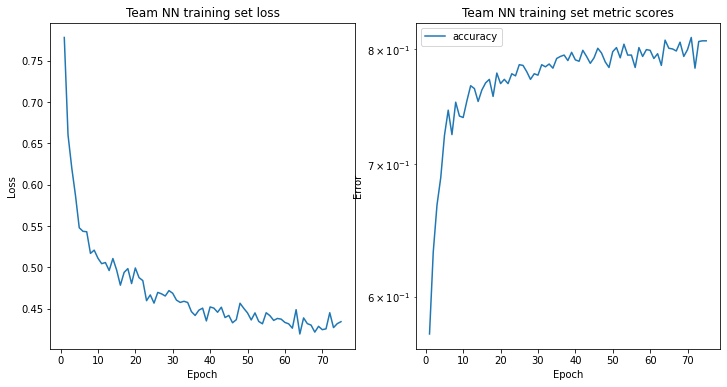

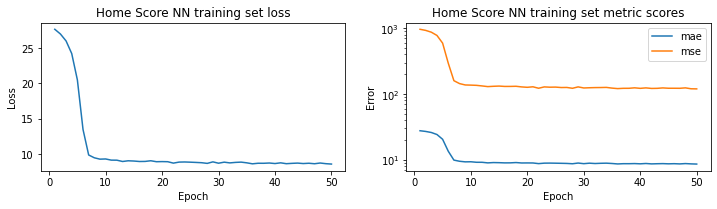

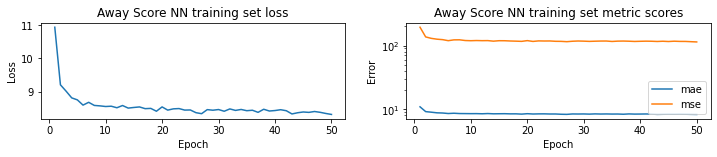

In [ ]:
plot_model_training(['Team NN', 'Home Score NN', 'Away Score NN'], [team_history, home_score_history, away_score_history], [team_epochs, score_epochs, score_epochs], [True, False, False])

In [ ]:
team_model.evaluate(x_test, y_test['winner_home'])
home_score_model.evaluate(x_test, y_test['home_points'])
away_score_model.evaluate(x_test, y_test['away_points'])

13/13 [==============================] - 0s 1ms/step - loss: 9.1786 - mse: 126.0960 - mae: 9.1786


[9.178643226623535, 126.09597778320312, 9.178643226623535]

In [ ]:
def show_feature_importance(model, features):
  std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
  importances = pd.Series(model.feature_importances_, index=features)
  fig, ax = plt.subplots()
  importances.plot.bar(yerr=std, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.set_size_inches(24, 7)

Predicting: winner_home
Model: Gradient Boosted
Accuracy of: 0.8



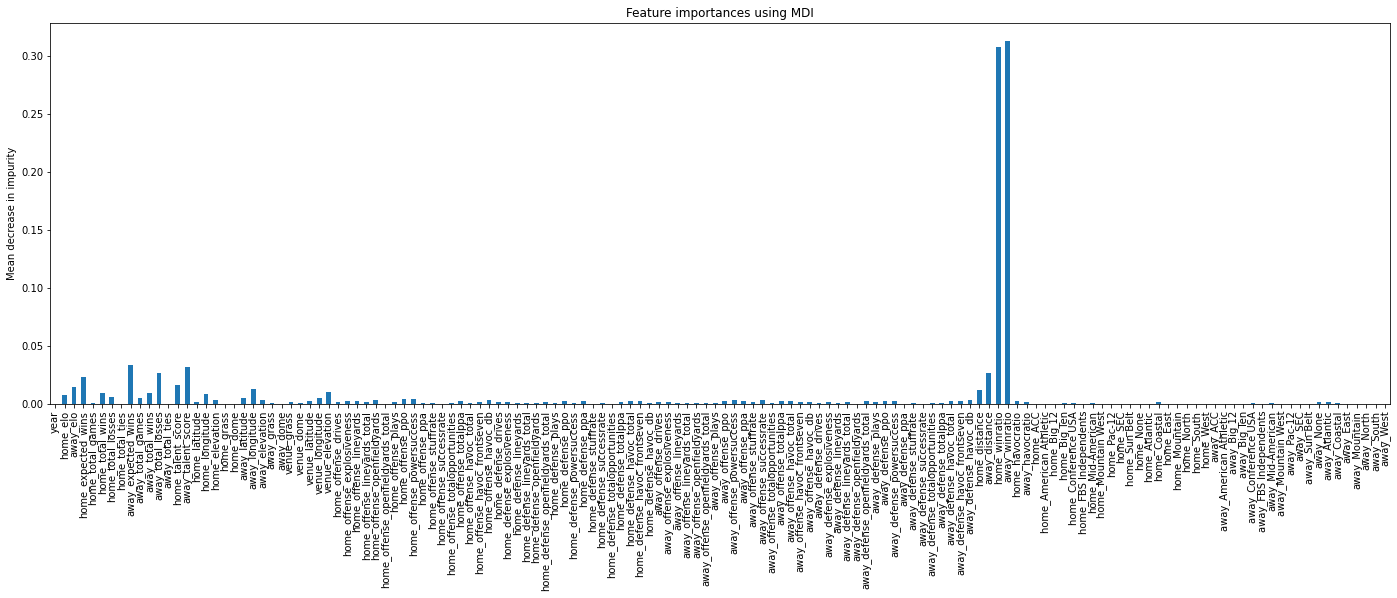

In [ ]:
# gradient boosting classifier for 'winner_home'
gbc = GradientBoostingClassifier(n_estimators=125, random_state=0)
gbc.fit(x_train.values, y_train['winner_home'].values)
gbcAccuracy = gbc.score(x_test.values, y_test['winner_home'].values)
print("Predicting: {}\nModel: {}\nAccuracy of: {}\n".format("winner_home", "Gradient Boosted", gbcAccuracy))

show_feature_importance(gbc, features)

In [ ]:
# LassoCV for predicated both teams scores
en1 = LassoCV()
en1.fit(x_train.values, y_train['home_points'].values)
en1Accuracy = en1.score(x_test.values, y_test['home_points'].values)

en2 = LassoCV()
en2.fit(x_train.values, y_train['away_points'].values)
en2Accuracy = en2.score(x_test.values, y_test['away_points'].values)

print("Predicting: {}\nModel: {}\nAccuracy: {}\n".format("home_points", "Lasso 1", en1Accuracy))
print("Predicting: {}\nModel: {}\nAccuracy: {}\n".format("away_points", "Lasso 2", en2Accuracy))

Predicting: home_points
Model: Lasso 1
Accuracy: 0.42439090213023856

Predicting: away_points
Model: Lasso 2
Accuracy: 0.34998066014847484



# MAKING NEW PREDICTIONS

## FUNCTIONS FOR INTERACTING WITH API

In [ ]:
# function to get current year as string
def current_year():
  return datetime.datetime.now().year

In [ ]:
# function to get season statistics for a given team
def get_team_season_stats(api, team, year):
  response = api.get_advanced_team_season_stats(year=year, team=team)
  return team_season_stats_to_dict(response[0])

In [ ]:
# function to get team season record
def get_team_season_record(api, team, year): 
  response = api.get_team_records(year=year, team=team)
  return team_season_to_dict(response[0])

In [ ]:
# function to get team general data
def get_team_data(api, team):
  response = api.get_teams()
  return team_to_dict([t for t in response if t.school == team][0])

In [ ]:
# function to get team talent metrics
def get_team_talent(api, team, year):
  response = api.get_talent(year=year)
  return team_talent_to_dict([t for t in response if t.school == team][0])

In [ ]:
# function to get team elo rating
def get_team_elo(api, team, year):
  response = api.get_elo_ratings(year=year)
  return rating_to_dict([t for t in response if t.team == team][0])

In [ ]:
# function to get venue information
def get_venue_info(api, venue):
  response = api.get_venues()
  return venues_to_dict([v for v in response if v.name == venue][0])

## FUNCTIONS FOR CREATING GAME DICTIONARIES

In [ ]:
# forms the basic game that is retreived from the gamesAPI for training the models
def form_base_game(year, team1, team2, venue, dict_teams, dict_ratings, dict_venues):
  home_team_info = [t for t in dict_teams if t['name'] == team1][0]
  away_team_info = [t for t in dict_teams if t['name'] == team2][0]
  home_elo = [r for r in dict_ratings if r['team'] == team1][0]
  away_elo = [r for r in dict_ratings if r['team'] == team2][0]
  try:
    venue_info = [v for v in dict_venues if v['name'] == venue][0]
  except:
    print("         ERROR: Stadium not found")
    venue_info = {'id' : 0}
  return dict(
      id = 0,
      venue_id = venue_info['id'],
      year = year,
      home_team = team1,
      away_team = team2,
      home_conference = home_team_info['conference'],
      away_conference = away_team_info['conference'],
      home_elo = home_elo['elo'],
      away_elo = away_elo['elo'],
      home_points = 0,
      away_points = 0)

In [ ]:
# function to create the full game dictionary row
def create_game(team1, team2, venue, dict_team_season_results, dict_teams_talent, dict_teams, dict_venues, dict_teams_season_stats, dict_ratings, verbose=False):
  if verbose:
    print("      ---------- BEGAN GAME CREATION ----------")
  # generate current year and make the base game to build off of
  year = current_year()

  if verbose:
    print("      Gathering Basic Information")

  dict_game = form_base_game(year, team1, team2, venue, dict_teams, dict_ratings, dict_venues)

  if verbose:
    print("      Gathering Season Records")
  # combine team results data into game dictionary
  home_result_data = [r for r in dict_team_season_results if r['team'] == dict_game['home_team'] and r['year'] == dict_game['year']]
  away_result_data = [r for r in dict_team_season_results if r['team'] == dict_game['away_team'] and r['year'] == dict_game['year']]
  if len(home_result_data) > 0:
    for key in home_result_data[0].keys():
      if key != 'team' and key != 'year':
        newKey = 'home_' + key
        dict_game[newKey] = home_result_data[0][key]
  if len(away_result_data) > 0:
    for key in away_result_data[0].keys():
      if key != 'team' and key != 'year':
        newKey = 'away_' + key
        dict_game[newKey] = away_result_data[0][key]

  if verbose:
    print("      Measuring Team Talent")
  # combine team talent data into the game dictionary
  home_talent_data = [t for t in dict_teams_talent if t['name'] == dict_game['home_team'] and t['year'] == dict_game['year']]
  away_talent_data = [t for t in dict_teams_talent if t['name'] == dict_game['away_team'] and t['year'] == dict_game['year']]
  if len(home_talent_data) > 0:
    dict_game['home_talent_score'] = home_talent_data[0]['talent_score']
  if len(away_talent_data) > 0:
    dict_game['away_talent_score'] = away_talent_data[0]['talent_score']

  if verbose:
    print("      Gathering Team Geography")
  # combine team geographical data into game dictionary
  home_geo_data = [g for g in dict_teams if g['name'] == dict_game['home_team']]
  away_geo_data = [g for g in dict_teams if g['name'] == dict_game['away_team']]
  if len(home_geo_data) > 0:
    for key in home_geo_data[0].keys():
      if key != 'id' and key != 'name' and key != 'conference' and key != 'division':
        newKey = 'home_' + key
        dict_game[newKey] = home_geo_data[0][key]
  if len(away_geo_data) > 0:
    for key in away_geo_data[0].keys():
      if key != 'id' and key != 'name' and key != 'conference' and key != 'division':
        newKey = 'away_' + key
        dict_game[newKey] = away_geo_data[0][key]

  if verbose:
    print("      Locating Venue")
  # combine venue information into game dictionary
  venue_stats = [v for v in dict_venues if v['id'] == dict_game['venue_id']]
  if len(venue_stats) > 0:
    for key in venue_stats[0].keys():
      if key != 'id':
        newKey = 'venue_' + key
        dict_game[newKey] = venue_stats[0][key]

  if verbose:
    print("      Computing Team Season Statistics")
  # combine team season data into the game dictionary
  home_stats = [t for t in dict_teams_season_stats if t['team'] == dict_game['home_team'] and t['season'] == dict_game['year']]
  away_stats = [t for t in dict_teams_season_stats if t['team'] == dict_game['away_team'] and t['season'] == dict_game['year']]
  for key in home_stats[0].keys():
    if key != 'team' and key != 'season' and key != 'conference':
      newKey = 'home_' + key
      dict_game[newKey] = home_stats[0][key]
  for key in away_stats[0].keys():
    if key != 'team' and key != 'season' and key != 'conference':
      newKey = 'away_' + key
      dict_game[newKey] = home_stats[0][key]

  if verbose:
    print("      --------- FINISHED GAME CREATION --------")

  return dict_game

## FUNCTIONS FOR USE ON GAME DATAFRAMES

In [ ]:
# fill in all metrics and data proessing for the game dataframe
def compute_metrics(df, old_data, verbose=False):
  df["winner_home"] = np.where(df['home_points'] > df['away_points'], True, False)  
  if verbose:
    print("      ----------- COMPUTING METRICS -----------")
    print("      Computing latitude, longitude, and elevation for teams and venue")
  for metric in ['latitude', 'longitude', 'elevation']:
    average_median_metric = (old_data['home_' + metric].median() + old_data['away_' + metric].median()) / 2.0
    median_metric_venue = old_data['venue_' + metric].median()
    try:
      df['home_' + metric].fillna(average_median_metric, inplace=True)
      df['away_' + metric].fillna(average_median_metric, inplace=True)
      df['venue_' + metric].fillna(median_metric_venue, inplace=True)
    except:
      df['home__' + metric] = np.nan
      df['away__' + metric] = np.nan
      df['venue__' + metric] = np.nan
      df['home_' + metric].fillna(average_median_metric, inplace=True)
      df['away_' + metric].fillna(average_median_metric, inplace=True)
      df['venue_' + metric].fillna(median_metric_venue, inplace=True)
  if verbose:
    print("      Forming teams home field & venue traits")
  for metric in ['grass', 'dome']:
    try:
      df['home_' + metric].fillna(False, inplace=True)
      df['away_' + metric].fillna(False, inplace=True)
      df['venue_' + metric].fillna(False, inplace=True)
    except:
      df['home__' + metric] = np.nan
      df['away__' + metric] = np.nan
      df['venue__' + metric] = np.nan
      df['home_' + metric].fillna(False, inplace=True)
      df['away_' + metric].fillna(False, inplace=True)
      df['venue_' + metric].fillna(False, inplace=True)
  if verbose:
    print("      Calculating team to venue distances")
  df['home_distance'] = df.apply(lambda row: calculate_distance(row, True), axis=1)
  df['away_distance'] = df.apply(lambda row: calculate_distance(row, False), axis=1)  
  if verbose:
    print("      Calculating team win ratios")
  df['home_winratio'] = df.apply(lambda row: calculate_winratio(row, True), axis=1)
  df['away_winratio'] = df.apply(lambda row: calculate_winratio(row, False), axis=1)
  if verbose:
    print("      Calculating team havoc scores")
  df['home_havocratio'] = df.apply(lambda row: calculate_havocratio(row, True), axis=1)
  df['away_havocratio'] = df.apply(lambda row: calculate_havocratio(row, False), axis=1)
  df['venue_name'] = df['venue_name'].fillna('Unnamed Venue')
  if verbose:
    print("      -------- DONE COMPUTING METRICS ---------")
  return df

In [ ]:
# performs the catagorical column splitting
# iterates over the manually entered catagorical columns
def split_catagorical_columns(df, catagorical_columns):
  for catagory in categorical_columns:
    col = df[catagory]
    # determines a prefix based on home or away
    if catagory[0:4] == 'home':
      prefix = 'home_'
    else:
      prefix = 'away_'
    # pandas will generate the dummy columns 
    new_cols = pd.get_dummies(col)
    # rename the columns to include the prefix
    new_renamed_cols = {}
    for col in new_cols.columns:
      if col == '' or col == ' ':
        new_renamed_cols[col] = prefix + 'None'
      else:
        new_renamed_cols[col] = prefix + col
  new_cols.rename(columns=new_renamed_cols, inplace=True)
  # add the new dummy columns to the dataset
  df = pd.concat([df, new_cols], axis=1)
  return df

In [ ]:
def reorganize_dataframe(df, info_cols):
  # pop and insert the columns in reverse order
  info_cols.reverse()
  for col in info_cols:
    df.insert(0, col, df.pop(col))
  return df

In [ ]:
# replace booleans with ints
def replace_bools(df):
  for col in df.columns:
    if df[col].dtype == 'bool':
      df[col] = df[col].astype('int64')
  return df

In [ ]:
# function to get the predication dataframe 
def get_features(df, info_cols, targets):
  # generate the features by excluding these two lists
  features = list(df.columns)
  for info_col in info_cols:
    features.remove(info_col)
  for target in targets:
    features.remove(target)

  featureDf = df[features]
  return featureDf

## FUNCTIONS FOR PREDICTED GAMES

In [ ]:
# function to print a predicted game
# predicted_game -> tuple of length 6
def print_predicted_game(predicted_game):
  chosen_team = predicted_game[0]
  confidence = predicted_game[1]
  team1 = predicted_game[2]
  team1_score = predicted_game[3]
  team2 = predicted_game[4]
  team2_score = predicted_game[5]
  print("      Winner: {} with {}% confidence".format(chosen_team, round(confidence * 100, 1)))
  print("      Game Result Predicted as:")
  print("         {}: {} vs. {}: {}\n".format(team1, team1_score, team2, team2_score))

In [ ]:
categorical_columns = ['home_conference', 'home_division', 'away_conference', 'away_division']
info_cols = ['id', 'venue_id', 'venue_name', 'home_team', 'home_conference', 'home_division', 'away_team', 'away_conference', 'away_division']
targets = ['home_points', 'away_points', 'winner_home']
# games_to_predict -> list of tuples (team1, team2, venue)
# team_model -> ml model that you can call .predict(features) on 
# score_model1 -> ml model that you can call .predict(features) on 
# score_model2 -> ml model that you can call .predict(features) on 
def predict_games(old_data, games_to_predict, team_model, score_model1, score_model2, categorical, info, targets, verbose=False):
  if verbose:
    print("-------------------- PREDICTING GAMES --------------------")
    print("Constructing API")
  # configure API key
  configuration = cfbd.Configuration()
  configuration.api_key['Authorization'] = '4OCTdkOLAKQ8szaP0w1Bqm/pCQ4yM053B9kTUwlN7/XN56Y9dOxidmYypMYAmr/I'
  configuration.api_key_prefix['Authorization'] = 'Bearer'

  # instantiate a games API instance
  api_config = cfbd.ApiClient(configuration)
  
  # load the specific apis to use
  # yearly apis
  games_api = cfbd.GamesApi(api_config)
  teams_api = cfbd.TeamsApi(api_config)
  ratings_api = cfbd.RatingsApi(api_config)
  drives_api = cfbd.DrivesApi(api_config)
  stats_api = cfbd.StatsApi(api_config)
  betting_api = cfbd.BettingApi(api_config)

  # static apis
  conferences_api = cfbd.ConferencesApi(api_config)
  venues_api = cfbd.VenuesApi(api_config)

  year = current_year()

  if verbose:
    print("Loading Data from API")
  # load the api 
  games = []
  teams = []
  teams_records = []
  teams_season_stats = []
  ratings = []
  teams_game_stats = []
  teams_talent = []
  venues = []

  if verbose:
    print("   Loading team records")
  teams_records_response = games_api.get_team_records(year=year)
  teams_records = [*teams_records, *teams_records_response]
  if verbose:
    print("   Loading team season statistics")
  season_stats_response = stats_api.get_advanced_team_season_stats(year=year)
  teams_season_stats = [*teams_season_stats, *season_stats_response]
  if verbose:
    print("   Loading team talent data")
  team_talent_response = teams_api.get_talent(year=year)
  teams_talent = [*teams_talent, *team_talent_response]
  if verbose:
    print("   Loading team ratings")
  response = ratings_api.get_elo_ratings(year=year)
  ratings = [*ratings, *response]
  if verbose:
    print("   Loading team general data")
  response = teams_api.get_teams()
  teams = [*teams, *response]
  if verbose:
    print("   Loading venue data")
  response = venues_api.get_venues()
  venues = [*venues, *response]
  if verbose:
    print("   Clearing invalid data")
  games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]
  teams = [t for t in teams if t.conference is not None and t.division is not None and t.location['latitude'] is not None and t.location['longitude'] is not None]
  venues = [v for v in venues if v.location is not None]
  teams_season_stats = [t for t in teams_season_stats if t.conference is not None]
  teams_game_stats = [g for g in teams_game_stats if g.offense is not None and g.defense is not None]
  if verbose:
    print("   Converting datatypes")
  dict_teams = [team_to_dict(t) for t in teams]
  dict_team_season_results = [team_season_to_dict(r) for r in teams_records]
  dict_teams_talent = [team_talent_to_dict(tt) for tt in teams_talent]
  dict_teams_season_stats = [team_season_stats_to_dict(ss) for ss in teams_season_stats]
  dict_venues = [venues_to_dict(v) for v in venues]
  dict_ratings = [rating_to_dict(r) for r in ratings]
  if verbose:
    print("   Completed data loading... DONE")

  predicted_games = []

  if verbose:
    print("Predicting Games")
  for game in games_to_predict:
    try:
      team1 = game[0]
      team2 = game[1]
      venue = game[2]

      if verbose:
        print("Processing Game: {} vs. {} @ {}".format(team1, team2, venue))
        print("   Creating Dataframe")
      game = pd.DataFrame.from_records(create_game(team1, team2, venue, dict_team_season_results, dict_teams_talent, dict_teams, dict_venues, dict_teams_season_stats, dict_ratings, verbose=verbose), index=[0])
      if verbose:
        print("   Computing Metrics")
      game = compute_metrics(game, old_data, verbose=verbose)
      if verbose:
        print("   Splitting Categorical Data")
      for category in categorical:
        assert category in game.columns
      game = split_catagorical_columns(game, categorical)

      if verbose:
        print("   Reorganizing Dataframe")
      for col in info:
        assert col in game.columns
      game = reorganize_dataframe(game, info)
      if verbose:
        print("   Removing Booleans")
      game = replace_bools(game)

      old_data = old_data.append(game)
      old_data.fillna(0, inplace=True)
      old_data = old_data.apply(pd.to_numeric, errors='coerce')
      game = old_data.iloc[-1:]

      if verbose:
        print("   Generating Features")
      features = get_features(game, info, targets)

      if verbose:
        print("   Running Models")
      team1_confidence = team_model.predict(features)[0][0]
      team1_score = score_model1.predict(features.values)
      team2_score = score_model2.predict(features.values)
      while type(team1_score) is np.ndarray:
        team1_score = team1_score[0]
      while type(team2_score) is np.ndarray:
        team2_score = team2_score[0]

      chosen_team = team1
      confidence = team1_confidence
      if team1_confidence < 0.5:
        chosen_team = team2
        confidence = 1.0 - team1_confidence

      pgame = (chosen_team, confidence, team1, team1_score, team2, team2_score)
      predicted_games.append(pgame)
      print_predicted_game(pgame)

      if verbose:
        print("   Predicted Game... DONE\n")
    except Exception as e:
      print("   ERROR!")
      print("   {}".format(e))
      print("      -> ERROR: Could Not Predict Game\n\n")
      predicted_games.append(("NULL: NO PREDICTION", 0.0, team1, 0.0, team2, 0.0))

  if verbose:
    print("--------------- FINISHED PREDICTING GAMES ----------------\n")

  print("--------------------- RECAP --------------------")
  for pgame in predicted_games:
    print_predicted_game(pgame)
  
  return predicted_games

In [ ]:
bowlgames = []
bowlgames.append(('Pittsburgh', 'Michigan State', 'Mercedes-Benz Stadium'))
bowlgames.append(('Wisconsin', 'Arizona State', 'Allegiant Stadium'))
bowlgames.append(('Wake Forest', 'Rutgers', 'TIAA Bank Field'))
bowlgames.append(('Cincinnati', 'Alabama', 'AT&T Stadium'))
bowlgames.append(('Georgia', 'Michigan', 'Hard Rock Stadium'))
bowlgames.append(('Penn State', 'Arkansas', 'Raymond James Stadium'))
bowlgames.append(('Oklahoma State', 'Notre Dame', 'State Farm Stadium'))
bowlgames.append(('Iowa', 'Kentucky', 'Camping World Stadium'))
bowlgames.append(('Utah', 'Ohio State', 'Rose Bowl'))
bowlgames.append(('Baylor', 'Ole Miss', 'Caesars Superdome'))
bowlgames.append(('LSU', 'Kansas State', 'NRG Stadium'))
bowlgames.append(('Georgia', 'Alabama', 'Lucas Oil Stadium'))
bowlgames.append(('Baylor', 'Ole Miss', 'Caesars Superdome'))

predicted_games = predict_games(df, bowlgames, team_model, home_score_model, away_score_model, categorical_columns, info_cols, targets, verbose=True)

-------------------- PREDICTING GAMES --------------------
Constructing API
Loading Data from API
   Loading team records
   Loading team season statistics
   Loading team talent data
   Loading team ratings
   Loading team general data
   Loading venue data
   Clearing invalid data
   Converting datatypes
   Completed data loading... DONE
Predicting Games
Processing Game: Pittsburgh vs. Michigan State @ Mercedes-Benz Stadium
   Creating Dataframe
      ---------- BEGAN GAME CREATION ----------
      Gathering Basic Information
   ERROR!
   list index out of range
      -> ERROR: Could Not Predict Game


Processing Game: Wisconsin vs. Arizona State @ Allegiant Stadium
   Creating Dataframe
      ---------- BEGAN GAME CREATION ----------
      Gathering Basic Information
   ERROR!
   list index out of range
      -> ERROR: Could Not Predict Game


Processing Game: Wake Forest vs. Rutgers @ TIAA Bank Field
   Creating Dataframe
      ---------- BEGAN GAME CREATION ----------
      Gather

In [ ]:
# https://www.geeksforgeeks.org/python-program-to-sort-a-list-of-tuples-by-second-item/
# Function to sort the list of tuples by its second item
def Sort_Tuple(tup, element): 
    lst = len(tup) 
    for i in range(0, lst): 
        for j in range(0, lst-i-1): 
            if (tup[j][element] < tup[j + 1][element]): 
                temp = tup[j] 
                tup[j]= tup[j + 1] 
                tup[j + 1]= temp 
    return tup 

In [ ]:
predicted_games = Sort_Tuple(predicted_games, 1)

In [ ]:
# games -> list of tuples of six elements
def report_confidences(games, num_bowl_games):
  for i in range(len(games)):
    print("{} Points Recommended".format(num_bowl_games - i))
    print_predicted_game(games[i])

In [ ]:
report_confidences(predicted_games, 44)

44 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Pittsburgh: 0.0 vs. Michigan State: 0.0

43 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Wisconsin: 0.0 vs. Arizona State: 0.0

42 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Wake Forest: 0.0 vs. Rutgers: 0.0

41 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Cincinnati: 0.0 vs. Alabama: 0.0

40 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Georgia: 0.0 vs. Michigan: 0.0

39 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence
      Game Result Predicted as:
         Penn State: 0.0 vs. Arkansas: 0.0

38 Points Recommended
      Winner: NULL: NO PREDICTION with 0.0% confidence

In [ ]:
team_model.save('new_model.h5')

In [ ]:
model = tf.keras.models.load_model('new_model.h5')

ValueError: ignored